In [41]:
import pandas as pd
import pprint

In [42]:
lyrics = pd.read_csv('../genius_lyrics21.csv')

LDA Model

In [43]:
docs = lyrics['lyrics'].tolist() #list of Unicode strings

In [44]:
# Tokenize the documents.
from nltk.tokenize import RegexpTokenizer

# Split the documents into tokens.
tokenizer = RegexpTokenizer(r'\w+')
for idx in range(len(docs)):
    docs[idx] = docs[idx].lower()  # Convert to lowercase.
    docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.

# Remove numbers, but not words that contain numbers.
docs = [[token for token in doc if not token.isnumeric()] for doc in docs]

# Remove words that are only one character.
docs = [[token for token in doc if len(token) > 1] for doc in docs]

#Removing stopwords:
from sklearn.feature_extraction import text
sw = ['oh','ooh','yeah','na','la','hey','like','da', 'feat',
      'whoa','uh','huh','doh','doo','ha','eh','ay','ayy','ll','re','ve','ft', 'yo'] #removing sounds, contractions and featured artists
stop_words= text.ENGLISH_STOP_WORDS.union(sw)

docs = [[token for token in doc if token not in stop_words] for doc in docs]

In [45]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\zylst\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [46]:
# Lemmatize the documents.
from nltk.stem.wordnet import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]

In [47]:
# Compute bigrams.
from gensim.models import Phrases

# Add bigrams and trigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(docs, min_count=20)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

2021-06-06 13:57:12,048 : INFO : collecting all words and their counts
2021-06-06 13:57:12,049 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2021-06-06 13:57:12,347 : INFO : collected 49676 token types (unigram + bigrams) from a corpus of 289603 words and 1362 sentences
2021-06-06 13:57:12,347 : INFO : merged Phrases<49676 vocab, min_count=20, threshold=10.0, max_vocab_size=40000000>
2021-06-06 13:57:12,348 : INFO : Phrases lifecycle event {'msg': 'built Phrases<49676 vocab, min_count=20, threshold=10.0, max_vocab_size=40000000> in 0.30s', 'datetime': '2021-06-06T13:57:12.348094', 'gensim': '4.0.1', 'python': '3.8.3 (default, Jul  2 2020, 17:30:36) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'created'}


In [48]:
# Remove rare and common tokens.
from gensim.corpora import Dictionary

# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=15, no_above=0.7)

2021-06-06 13:57:12,789 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2021-06-06 13:57:12,986 : INFO : built Dictionary(10561 unique tokens: ['babe', 'blonde', 'blue', 'car', 'cause']...) from 1362 documents (total 326040 corpus positions)
2021-06-06 13:57:12,988 : INFO : Dictionary lifecycle event {'msg': "built Dictionary(10561 unique tokens: ['babe', 'blonde', 'blue', 'car', 'cause']...) from 1362 documents (total 326040 corpus positions)", 'datetime': '2021-06-06T13:57:12.988977', 'gensim': '4.0.1', 'python': '3.8.3 (default, Jul  2 2020, 17:30:36) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'created'}
2021-06-06 13:57:13,010 : INFO : discarding 8433 tokens: [('blonde', 14), ('drive_past', 14), ('imagine_okay', 14), ('know', 1031), ('mean_wrote', 14), ('pictured', 14), ('suburb', 14), ('today_drove', 14), ('traffic', 14), ('weren_perfect', 14)]...
2021-06-06 13:57:13,010 : INFO : keeping 2128 tokens which were in no less than 15 

In [49]:
# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in docs]

In [50]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 2128
Number of documents: 1362


In [51]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO) #enable logging

In [116]:
# Train LDA model.
from gensim.models import LdaModel

# Set training parameters.
num_topics = 2
chunksize = 2000
passes = 20
iterations = 1000
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha=1,
    eta=0.001,
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)

2021-06-06 14:52:44,866 : INFO : using serial LDA version on this node
2021-06-06 14:52:44,867 : INFO : running online (multi-pass) LDA training, 2 topics, 20 passes over the supplied corpus of 1362 documents, updating model once every 1362 documents, evaluating perplexity every 0 documents, iterating 1000x with a convergence threshold of 0.001000
2021-06-06 14:52:44,869 : INFO : PROGRESS: pass 0, at document #1362/1362
2021-06-06 14:52:47,978 : INFO : topic #0 (1.000): 0.016*"got" + 0.016*"love" + 0.014*"ain" + 0.013*"nigga" + 0.009*"just" + 0.009*"shit" + 0.009*"time" + 0.009*"baby" + 0.008*"way" + 0.008*"good"
2021-06-06 14:52:47,979 : INFO : topic #1 (1.000): 0.015*"got" + 0.013*"let" + 0.011*"bitch" + 0.011*"just" + 0.010*"ain" + 0.009*"nigga" + 0.009*"love" + 0.009*"make" + 0.008*"need" + 0.008*"come"
2021-06-06 14:52:47,980 : INFO : topic diff=0.904850, rho=1.000000
2021-06-06 14:52:47,981 : INFO : PROGRESS: pass 1, at document #1362/1362
2021-06-06 14:52:48,916 : INFO : topic #

2021-06-06 14:52:57,467 : INFO : topic diff=2.068394, rho=0.250000
2021-06-06 14:52:57,468 : INFO : PROGRESS: pass 15, at document #1362/1362
2021-06-06 14:52:57,882 : INFO : topic #0 (1.000): 0.021*"love" + 0.015*"got" + 0.013*"just" + 0.012*"ain" + 0.012*"way" + 0.012*"baby" + 0.012*"time" + 0.011*"good" + 0.009*"cause" + 0.009*"right"
2021-06-06 14:52:57,883 : INFO : topic #1 (1.000): 0.017*"nigga" + 0.016*"got" + 0.015*"bitch" + 0.012*"ain" + 0.011*"let" + 0.010*"shit" + 0.009*"come" + 0.008*"make" + 0.008*"just" + 0.007*"fuck"
2021-06-06 14:52:57,884 : INFO : topic diff=2.514053, rho=0.242536
2021-06-06 14:52:57,884 : INFO : PROGRESS: pass 16, at document #1362/1362
2021-06-06 14:52:58,306 : INFO : topic #0 (1.000): 0.021*"love" + 0.015*"got" + 0.013*"just" + 0.012*"way" + 0.012*"ain" + 0.012*"time" + 0.012*"baby" + 0.011*"good" + 0.009*"cause" + 0.009*"right"
2021-06-06 14:52:58,307 : INFO : topic #1 (1.000): 0.017*"nigga" + 0.016*"got" + 0.015*"bitch" + 0.012*"ain" + 0.011*"let"

In [120]:
top_topics = model.top_topics(corpus) #, num_words=20)

from pprint import pprint
pprint(top_topics)

2021-06-06 14:56:44,567 : INFO : CorpusAccumulator accumulated stats from 1000 documents


[([(0.021115473, 'love'),
   (0.014744887, 'got'),
   (0.013447964, 'just'),
   (0.012451327, 'way'),
   (0.012085856, 'ain'),
   (0.012058619, 'time'),
   (0.01202913, 'baby'),
   (0.011291702, 'good'),
   (0.0093788635, 'cause'),
   (0.008797351, 'say'),
   (0.008713469, 'right'),
   (0.00851367, 'let'),
   (0.008237409, 'young'),
   (0.007886498, 'girl'),
   (0.0076686367, 'make'),
   (0.0075963903, 'tell'),
   (0.007409602, 'feel'),
   (0.0072679436, 'life'),
   (0.0070555094, 'heart'),
   (0.006897995, 'gonna')],
  -1.0766661692191628),
 ([(0.017415559, 'nigga'),
   (0.015782408, 'got'),
   (0.0156228235, 'bitch'),
   (0.011998631, 'ain'),
   (0.010650818, 'let'),
   (0.0098116025, 'shit'),
   (0.008601264, 'come'),
   (0.0080219805, 'make'),
   (0.007788906, 'just'),
   (0.0076409024, 'fuck'),
   (0.007215833, 'man'),
   (0.0070798583, 'need'),
   (0.006985152, 'night'),
   (0.0069030025, 'gon'),
   (0.0068474105, 'day'),
   (0.006059008, 'mind'),
   (0.0060550766, 'anderson'),
 

## Calculating our coherence score:
good explanation here: https://stackoverflow.com/questions/54762690/what-is-the-meaning-of-coherence-score-0-4-is-it-good-or-bad

In [118]:
from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=model, texts=docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

2021-06-06 14:53:00,860 : INFO : using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-06-06 14:53:02,133 : INFO : 1 batches submitted to accumulate stats from 64 documents (7366 virtual)
2021-06-06 14:53:02,149 : INFO : 2 batches submitted to accumulate stats from 128 documents (15592 virtual)
2021-06-06 14:53:02,163 : INFO : 3 batches submitted to accumulate stats from 192 documents (23764 virtual)
2021-06-06 14:53:02,177 : INFO : 4 batches submitted to accumulate stats from 256 documents (32339 virtual)
2021-06-06 14:53:02,194 : INFO : 5 batches submitted to accumulate stats from 320 documents (41622 virtual)
2021-06-06 14:53:02,212 : INFO : 6 batches submitted to accumulate stats from 384 documents (51645 virtual)
2021-06-06 14:53:02,227 : INFO : 7 batches submitted to accumulate stats from 448 documents (58644 virtual)
2021-06-06 14:53:03,116 : INFO : 8 batches submitted to accumulate stats from 512 documents (67591


Coherence Score:  0.5168106330864966


## Fine tuning hyperparameters
* alpha = 1 seems to give best results
* beta either default of 0.01 or 0.001
* number of topics 2 or 7--for the purpose of the data question, two seems more fitting


In [87]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(
            corpus=corpus,
            id2word=id2word,
            chunksize=chunksize,
            alpha=1,
            eta=.001,
            iterations=iterations,
            num_topics=num_topics,
            passes=passes,
            eval_every=eval_every
        )
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

2021-06-06 14:41:45,543 : INFO : using serial LDA version on this node
2021-06-06 14:41:45,544 : INFO : running online (multi-pass) LDA training, 1 topics, 20 passes over the supplied corpus of 1362 documents, updating model once every 1362 documents, evaluating perplexity every 0 documents, iterating 200x with a convergence threshold of 0.001000
2021-06-06 14:41:45,545 : INFO : PROGRESS: pass 0, at document #1362/1362
2021-06-06 14:41:45,651 : INFO : topic #0 (1.000): 0.015*"got" + 0.012*"ain" + 0.012*"love" + 0.011*"nigga" + 0.010*"just" + 0.010*"let" + 0.010*"bitch" + 0.008*"shit" + 0.008*"make" + 0.008*"time"
2021-06-06 14:41:45,652 : INFO : topic diff=0.822141, rho=1.000000
2021-06-06 14:41:45,652 : INFO : PROGRESS: pass 1, at document #1362/1362
2021-06-06 14:41:45,748 : INFO : topic #0 (1.000): 0.015*"got" + 0.012*"ain" + 0.012*"love" + 0.011*"nigga" + 0.010*"just" + 0.010*"let" + 0.010*"bitch" + 0.008*"shit" + 0.008*"make" + 0.008*"time"
2021-06-06 14:41:45,748 : INFO : topic d

2021-06-06 14:41:48,271 : INFO : 7 batches submitted to accumulate stats from 448 documents (58644 virtual)
2021-06-06 14:41:48,972 : INFO : 8 batches submitted to accumulate stats from 512 documents (67591 virtual)
2021-06-06 14:41:49,041 : INFO : 9 batches submitted to accumulate stats from 576 documents (74935 virtual)
2021-06-06 14:41:49,203 : INFO : 10 batches submitted to accumulate stats from 640 documents (82334 virtual)
2021-06-06 14:41:49,221 : INFO : 11 batches submitted to accumulate stats from 704 documents (91947 virtual)
2021-06-06 14:41:49,288 : INFO : 12 batches submitted to accumulate stats from 768 documents (98438 virtual)
2021-06-06 14:41:49,352 : INFO : 13 batches submitted to accumulate stats from 832 documents (105641 virtual)
2021-06-06 14:41:49,432 : INFO : 14 batches submitted to accumulate stats from 896 documents (112856 virtual)
2021-06-06 14:41:49,453 : INFO : 15 batches submitted to accumulate stats from 960 documents (121661 virtual)
2021-06-06 14:41:49

2021-06-06 14:41:58,473 : INFO : PROGRESS: pass 11, at document #1362/1362
2021-06-06 14:41:59,408 : INFO : topic #0 (1.000): 0.016*"love" + 0.016*"got" + 0.013*"let" + 0.012*"way" + 0.012*"just" + 0.011*"time" + 0.011*"ain" + 0.010*"need" + 0.009*"baby" + 0.009*"good"
2021-06-06 14:41:59,410 : INFO : topic #1 (1.000): 0.021*"nigga" + 0.015*"got" + 0.015*"bitch" + 0.014*"ain" + 0.011*"shit" + 0.009*"make" + 0.008*"que" + 0.008*"just" + 0.008*"anderson" + 0.007*"love"
2021-06-06 14:41:59,410 : INFO : topic diff=1.211243, rho=0.277350
2021-06-06 14:41:59,411 : INFO : PROGRESS: pass 12, at document #1362/1362
2021-06-06 14:42:00,332 : INFO : topic #0 (1.000): 0.016*"love" + 0.016*"got" + 0.013*"let" + 0.012*"way" + 0.012*"just" + 0.011*"time" + 0.011*"ain" + 0.010*"need" + 0.009*"baby" + 0.009*"good"
2021-06-06 14:42:00,333 : INFO : topic #1 (1.000): 0.021*"nigga" + 0.015*"bitch" + 0.015*"got" + 0.014*"ain" + 0.011*"shit" + 0.009*"make" + 0.008*"que" + 0.008*"just" + 0.008*"anderson" + 0.

2021-06-06 14:42:06,838 : INFO : PROGRESS: pass 0, at document #1362/1362
2021-06-06 14:42:09,418 : INFO : topic #0 (1.000): 0.017*"bitch" + 0.014*"love" + 0.014*"nigga" + 0.014*"ain" + 0.013*"got" + 0.010*"shit" + 0.009*"let" + 0.009*"just" + 0.008*"blrrrd" + 0.007*"need"
2021-06-06 14:42:09,419 : INFO : topic #1 (1.000): 0.018*"got" + 0.016*"ain" + 0.014*"love" + 0.014*"nigga" + 0.011*"bitch" + 0.010*"shit" + 0.008*"baby" + 0.008*"cause" + 0.008*"just" + 0.007*"let"
2021-06-06 14:42:09,420 : INFO : topic #2 (1.000): 0.015*"got" + 0.012*"just" + 0.012*"let" + 0.010*"time" + 0.009*"make" + 0.009*"night" + 0.009*"mind" + 0.009*"way" + 0.009*"baby" + 0.009*"ain"
2021-06-06 14:42:09,420 : INFO : topic diff=0.973894, rho=1.000000
2021-06-06 14:42:09,421 : INFO : PROGRESS: pass 1, at document #1362/1362
2021-06-06 14:42:10,424 : INFO : topic #0 (1.000): 0.017*"bitch" + 0.014*"love" + 0.013*"nigga" + 0.013*"got" + 0.012*"ain" + 0.010*"shit" + 0.009*"let" + 0.009*"que" + 0.008*"just" + 0.008*

2021-06-06 14:42:15,337 : INFO : topic #1 (1.000): 0.022*"got" + 0.021*"nigga" + 0.019*"ain" + 0.013*"bitch" + 0.013*"shit" + 0.012*"love" + 0.011*"just" + 0.010*"fuck" + 0.010*"young" + 0.008*"make"
2021-06-06 14:42:15,338 : INFO : topic #2 (1.000): 0.014*"love" + 0.014*"let" + 0.013*"just" + 0.013*"good" + 0.013*"mind" + 0.013*"way" + 0.012*"time" + 0.012*"got" + 0.011*"night" + 0.010*"think"
2021-06-06 14:42:15,338 : INFO : topic diff=2.653287, rho=0.277350
2021-06-06 14:42:15,340 : INFO : PROGRESS: pass 12, at document #1362/1362
2021-06-06 14:42:15,761 : INFO : topic #0 (1.000): 0.019*"bitch" + 0.014*"que" + 0.012*"nigga" + 0.011*"shit" + 0.011*"got" + 0.010*"blrrrd" + 0.010*"lo" + 0.010*"come" + 0.010*"let" + 0.009*"ain"
2021-06-06 14:42:15,763 : INFO : topic #1 (1.000): 0.022*"got" + 0.021*"nigga" + 0.019*"ain" + 0.013*"bitch" + 0.013*"shit" + 0.011*"love" + 0.011*"just" + 0.010*"fuck" + 0.010*"young" + 0.008*"make"
2021-06-06 14:42:15,764 : INFO : topic #2 (1.000): 0.015*"love"

2021-06-06 14:42:20,850 : INFO : 14 batches submitted to accumulate stats from 896 documents (113035 virtual)
2021-06-06 14:42:20,963 : INFO : 15 batches submitted to accumulate stats from 960 documents (121550 virtual)
2021-06-06 14:42:20,976 : INFO : 16 batches submitted to accumulate stats from 1024 documents (129243 virtual)
2021-06-06 14:42:21,121 : INFO : 17 batches submitted to accumulate stats from 1088 documents (137022 virtual)
2021-06-06 14:42:21,147 : INFO : 18 batches submitted to accumulate stats from 1152 documents (143723 virtual)
2021-06-06 14:42:21,202 : INFO : 19 batches submitted to accumulate stats from 1216 documents (155536 virtual)
2021-06-06 14:42:21,247 : INFO : 20 batches submitted to accumulate stats from 1280 documents (165254 virtual)
2021-06-06 14:42:21,357 : INFO : 21 batches submitted to accumulate stats from 1344 documents (176760 virtual)
2021-06-06 14:42:21,458 : INFO : 22 batches submitted to accumulate stats from 1408 documents (177552 virtual)
202

2021-06-06 14:42:29,471 : INFO : topic #1 (1.000): 0.021*"mind" + 0.021*"love" + 0.016*"got" + 0.015*"time" + 0.013*"ain" + 0.011*"day" + 0.011*"just" + 0.011*"way" + 0.011*"good" + 0.010*"shit"
2021-06-06 14:42:29,472 : INFO : topic #2 (1.000): 0.024*"que" + 0.023*"anderson" + 0.017*"lo" + 0.017*"nah" + 0.013*"si" + 0.012*"te" + 0.011*"ya" + 0.010*"el" + 0.009*"sí" + 0.008*"noche"
2021-06-06 14:42:29,472 : INFO : topic #3 (1.000): 0.024*"nigga" + 0.021*"got" + 0.020*"bitch" + 0.017*"ain" + 0.013*"just" + 0.013*"let" + 0.012*"shit" + 0.009*"fuck" + 0.009*"gon" + 0.009*"make"
2021-06-06 14:42:29,473 : INFO : topic diff=1.854797, rho=0.333333
2021-06-06 14:42:29,474 : INFO : PROGRESS: pass 8, at document #1362/1362
2021-06-06 14:42:29,947 : INFO : topic #0 (1.000): 0.017*"need" + 0.015*"young" + 0.015*"life" + 0.015*"love" + 0.013*"got" + 0.012*"baby" + 0.010*"way" + 0.010*"ain" + 0.009*"say" + 0.009*"right"
2021-06-06 14:42:29,948 : INFO : topic #1 (1.000): 0.021*"mind" + 0.021*"love" +

2021-06-06 14:42:33,654 : INFO : topic #1 (1.000): 0.020*"mind" + 0.020*"love" + 0.016*"got" + 0.015*"time" + 0.014*"good" + 0.013*"ain" + 0.012*"just" + 0.012*"day" + 0.011*"way" + 0.010*"long"
2021-06-06 14:42:33,655 : INFO : topic #2 (1.000): 0.026*"que" + 0.025*"anderson" + 0.018*"lo" + 0.018*"nah" + 0.014*"si" + 0.013*"te" + 0.011*"ya" + 0.011*"el" + 0.010*"sí" + 0.009*"noche"
2021-06-06 14:42:33,656 : INFO : topic #3 (1.000): 0.024*"nigga" + 0.021*"got" + 0.020*"bitch" + 0.018*"ain" + 0.013*"let" + 0.013*"just" + 0.012*"shit" + 0.009*"fuck" + 0.009*"gon" + 0.009*"make"
2021-06-06 14:42:33,657 : INFO : topic diff=11.586938, rho=0.235702
2021-06-06 14:42:33,658 : INFO : PROGRESS: pass 17, at document #1362/1362
2021-06-06 14:42:34,121 : INFO : topic #0 (1.000): 0.018*"need" + 0.016*"young" + 0.016*"life" + 0.015*"love" + 0.012*"got" + 0.012*"baby" + 0.011*"way" + 0.010*"say" + 0.009*"right" + 0.009*"ain"
2021-06-06 14:42:34,122 : INFO : topic #1 (1.000): 0.020*"love" + 0.020*"mind"

2021-06-06 14:42:43,122 : INFO : topic #1 (1.000): 0.023*"nigga" + 0.021*"got" + 0.015*"let" + 0.014*"ain" + 0.014*"bitch" + 0.013*"shit" + 0.012*"time" + 0.010*"just" + 0.009*"fuck" + 0.009*"gon"
2021-06-06 14:42:43,122 : INFO : topic #2 (1.000): 0.014*"young" + 0.012*"nah" + 0.011*"life" + 0.011*"need" + 0.011*"make" + 0.010*"love" + 0.009*"tryin" + 0.009*"man" + 0.009*"got" + 0.008*"bitch"
2021-06-06 14:42:43,124 : INFO : topic #3 (1.000): 0.021*"got" + 0.013*"just" + 0.011*"let" + 0.010*"baby" + 0.010*"love" + 0.010*"wanna" + 0.010*"need" + 0.009*"way" + 0.009*"time" + 0.009*"friend"
2021-06-06 14:42:43,124 : INFO : topic #4 (1.000): 0.018*"love" + 0.018*"ain" + 0.017*"anderson" + 0.015*"got" + 0.015*"just" + 0.011*"que" + 0.009*"think" + 0.009*"good" + 0.008*"bitch" + 0.008*"time"
2021-06-06 14:42:43,125 : INFO : topic diff=0.529235, rho=0.577350
2021-06-06 14:42:43,126 : INFO : PROGRESS: pass 2, at document #1362/1362
2021-06-06 14:42:43,818 : INFO : topic #0 (1.000): 0.022*"mind

2021-06-06 14:42:46,905 : INFO : topic #3 (1.000): 0.024*"got" + 0.013*"just" + 0.011*"wanna" + 0.011*"baby" + 0.011*"need" + 0.011*"let" + 0.010*"away" + 0.010*"friend" + 0.010*"time" + 0.010*"love"
2021-06-06 14:42:46,907 : INFO : topic #4 (1.000): 0.026*"love" + 0.021*"anderson" + 0.016*"ain" + 0.016*"just" + 0.015*"good" + 0.011*"gonna" + 0.011*"que" + 0.010*"think" + 0.009*"cause" + 0.009*"time"
2021-06-06 14:42:46,907 : INFO : topic diff=2.756733, rho=0.316228
2021-06-06 14:42:46,908 : INFO : PROGRESS: pass 9, at document #1362/1362
2021-06-06 14:42:47,377 : INFO : topic #0 (1.000): 0.027*"mind" + 0.017*"love" + 0.015*"way" + 0.014*"make" + 0.012*"need" + 0.011*"ain" + 0.011*"mmm" + 0.011*"baby" + 0.011*"hold" + 0.011*"ah"
2021-06-06 14:42:47,378 : INFO : topic #1 (1.000): 0.031*"nigga" + 0.024*"got" + 0.020*"bitch" + 0.018*"ain" + 0.016*"shit" + 0.014*"let" + 0.011*"gon" + 0.011*"time" + 0.010*"just" + 0.010*"fuck"
2021-06-06 14:42:47,379 : INFO : topic #2 (1.000): 0.020*"young"

2021-06-06 14:42:50,180 : INFO : topic diff=11.667099, rho=0.242536
2021-06-06 14:42:50,181 : INFO : PROGRESS: pass 16, at document #1362/1362
2021-06-06 14:42:50,640 : INFO : topic #0 (1.000): 0.028*"mind" + 0.017*"love" + 0.016*"way" + 0.015*"make" + 0.013*"need" + 0.011*"mmm" + 0.011*"ah" + 0.011*"ain" + 0.011*"baby" + 0.011*"hold"
2021-06-06 14:42:50,641 : INFO : topic #1 (1.000): 0.033*"nigga" + 0.025*"got" + 0.022*"bitch" + 0.019*"ain" + 0.016*"shit" + 0.014*"let" + 0.011*"gon" + 0.010*"time" + 0.010*"fuck" + 0.010*"just"
2021-06-06 14:42:50,641 : INFO : topic #2 (1.000): 0.022*"que" + 0.020*"young" + 0.018*"nah" + 0.016*"lo" + 0.014*"life" + 0.013*"si" + 0.011*"te" + 0.011*"tryin" + 0.009*"stoner" + 0.009*"man"
2021-06-06 14:42:50,642 : INFO : topic #3 (1.000): 0.025*"got" + 0.013*"just" + 0.012*"wanna" + 0.012*"need" + 0.011*"baby" + 0.011*"let" + 0.011*"friend" + 0.011*"away" + 0.010*"time" + 0.009*"girl"
2021-06-06 14:42:50,643 : INFO : topic #4 (1.000): 0.030*"love" + 0.022*

2021-06-06 14:42:59,015 : INFO : topic #1 (1.000): 0.019*"got" + 0.013*"time" + 0.011*"tryin" + 0.011*"nigga" + 0.010*"let" + 0.009*"girl" + 0.009*"love" + 0.009*"bitch" + 0.009*"day" + 0.009*"just"
2021-06-06 14:42:59,015 : INFO : topic #3 (1.000): 0.013*"nigga" + 0.012*"young" + 0.011*"ain" + 0.010*"got" + 0.010*"mind" + 0.010*"need" + 0.010*"love" + 0.009*"life" + 0.009*"make" + 0.009*"way"
2021-06-06 14:42:59,016 : INFO : topic #0 (1.000): 0.018*"ain" + 0.017*"got" + 0.015*"love" + 0.014*"nigga" + 0.014*"bitch" + 0.012*"just" + 0.011*"baby" + 0.010*"shit" + 0.010*"make" + 0.009*"let"
2021-06-06 14:42:59,017 : INFO : topic #4 (1.000): 0.018*"let" + 0.014*"just" + 0.014*"que" + 0.012*"night" + 0.011*"got" + 0.010*"nah" + 0.009*"lo" + 0.008*"anderson" + 0.008*"love" + 0.008*"ain"
2021-06-06 14:42:59,018 : INFO : topic diff=1.056555, rho=1.000000
2021-06-06 14:42:59,019 : INFO : PROGRESS: pass 1, at document #1362/1362
2021-06-06 14:43:00,229 : INFO : topic #4 (1.000): 0.023*"let" + 0.

2021-06-06 14:43:03,542 : INFO : topic #4 (1.000): 0.038*"que" + 0.030*"let" + 0.026*"lo" + 0.026*"nah" + 0.020*"si" + 0.018*"te" + 0.017*"just" + 0.015*"night" + 0.014*"sí" + 0.013*"el"
2021-06-06 14:43:03,543 : INFO : topic #5 (1.000): 0.031*"love" + 0.015*"way" + 0.014*"just" + 0.014*"night" + 0.014*"ah" + 0.013*"long" + 0.013*"cause" + 0.011*"tell" + 0.011*"girl" + 0.011*"live"
2021-06-06 14:43:03,544 : INFO : topic diff=2.603903, rho=0.333333
2021-06-06 14:43:03,544 : INFO : PROGRESS: pass 8, at document #1362/1362
2021-06-06 14:43:03,998 : INFO : topic #2 (1.000): 0.020*"anderson" + 0.018*"got" + 0.013*"run" + 0.013*"shit" + 0.011*"ain" + 0.010*"way" + 0.009*"right" + 0.009*"did" + 0.009*"time" + 0.008*"love"
2021-06-06 14:43:03,999 : INFO : topic #0 (1.000): 0.027*"nigga" + 0.021*"bitch" + 0.021*"ain" + 0.021*"got" + 0.013*"shit" + 0.013*"make" + 0.013*"just" + 0.012*"baby" + 0.010*"love" + 0.010*"let"
2021-06-06 14:43:04,000 : INFO : topic #4 (1.000): 0.038*"que" + 0.030*"let" 

2021-06-06 14:43:06,932 : INFO : topic diff=12.722126, rho=0.250000
2021-06-06 14:43:06,933 : INFO : PROGRESS: pass 15, at document #1362/1362
2021-06-06 14:43:07,408 : INFO : topic #1 (1.000): 0.022*"got" + 0.015*"tryin" + 0.015*"day" + 0.015*"good" + 0.012*"time" + 0.011*"let" + 0.011*"okay" + 0.010*"bitch" + 0.010*"think" + 0.009*"ain"
2021-06-06 14:43:07,409 : INFO : topic #5 (1.000): 0.038*"love" + 0.018*"way" + 0.016*"just" + 0.015*"cause" + 0.014*"night" + 0.013*"long" + 0.013*"ah" + 0.013*"girl" + 0.012*"time" + 0.012*"tell"
2021-06-06 14:43:07,410 : INFO : topic #3 (1.000): 0.034*"mind" + 0.023*"young" + 0.019*"life" + 0.018*"need" + 0.014*"mmm" + 0.011*"hold" + 0.010*"stoner" + 0.010*"thug" + 0.009*"woah" + 0.009*"young_thug"
2021-06-06 14:43:07,410 : INFO : topic #2 (1.000): 0.021*"anderson" + 0.018*"got" + 0.014*"run" + 0.012*"shit" + 0.010*"way" + 0.010*"right" + 0.009*"ain" + 0.009*"did" + 0.009*"time" + 0.009*"say"
2021-06-06 14:43:07,410 : INFO : topic #0 (1.000): 0.029

2021-06-06 14:43:12,413 : INFO : 19 batches submitted to accumulate stats from 1216 documents (155536 virtual)
2021-06-06 14:43:12,503 : INFO : 20 batches submitted to accumulate stats from 1280 documents (165254 virtual)
2021-06-06 14:43:12,613 : INFO : 21 batches submitted to accumulate stats from 1344 documents (176760 virtual)
2021-06-06 14:43:12,674 : INFO : 22 batches submitted to accumulate stats from 1408 documents (177552 virtual)
2021-06-06 14:43:13,864 : INFO : 7 accumulators retrieved from output queue
2021-06-06 14:43:13,881 : INFO : accumulated word occurrence stats for 179330 virtual documents
2021-06-06 14:43:14,135 : INFO : using serial LDA version on this node
2021-06-06 14:43:14,138 : INFO : running online (multi-pass) LDA training, 7 topics, 20 passes over the supplied corpus of 1362 documents, updating model once every 1362 documents, evaluating perplexity every 0 documents, iterating 200x with a convergence threshold of 0.001000
2021-06-06 14:43:14,138 : INFO : PR

2021-06-06 14:43:20,524 : INFO : topic #1 (1.000): 0.020*"nigga" + 0.019*"ain" + 0.018*"young" + 0.017*"got" + 0.013*"time" + 0.012*"shit" + 0.012*"need" + 0.012*"life" + 0.011*"love" + 0.011*"just"
2021-06-06 14:43:20,525 : INFO : topic #4 (1.000): 0.031*"bitch" + 0.020*"nigga" + 0.018*"mind" + 0.013*"gon" + 0.013*"mmm" + 0.013*"as" + 0.012*"good" + 0.012*"ain" + 0.011*"let" + 0.011*"ah"
2021-06-06 14:43:20,525 : INFO : topic #0 (1.000): 0.026*"got" + 0.016*"nah" + 0.014*"just" + 0.013*"ain" + 0.012*"nigga" + 0.011*"love" + 0.011*"bitch" + 0.010*"fuck" + 0.009*"em" + 0.009*"way"
2021-06-06 14:43:20,526 : INFO : topic diff=2.294075, rho=0.353553
2021-06-06 14:43:20,527 : INFO : PROGRESS: pass 7, at document #1362/1362
2021-06-06 14:43:20,996 : INFO : topic #3 (1.000): 0.037*"love" + 0.020*"gonna" + 0.018*"baby" + 0.017*"girl" + 0.015*"make" + 0.014*"way" + 0.014*"ain" + 0.013*"got" + 0.012*"good" + 0.012*"cause"
2021-06-06 14:43:20,997 : INFO : topic #4 (1.000): 0.032*"bitch" + 0.021*"

2021-06-06 14:43:23,849 : INFO : topic #3 (1.000): 0.041*"love" + 0.022*"gonna" + 0.019*"girl" + 0.019*"baby" + 0.016*"make" + 0.016*"way" + 0.014*"ain" + 0.014*"good" + 0.013*"cause" + 0.012*"just"
2021-06-06 14:43:23,850 : INFO : topic diff=12.639360, rho=0.258199
2021-06-06 14:43:23,851 : INFO : PROGRESS: pass 14, at document #1362/1362
2021-06-06 14:43:24,339 : INFO : topic #2 (1.000): 0.029*"anderson" + 0.019*"long" + 0.017*"time" + 0.014*"say" + 0.013*"live" + 0.013*"life" + 0.013*"make" + 0.013*"feel" + 0.012*"cause" + 0.011*"need"
2021-06-06 14:43:24,340 : INFO : topic #0 (1.000): 0.028*"got" + 0.016*"nah" + 0.015*"nigga" + 0.014*"just" + 0.014*"ain" + 0.012*"bitch" + 0.011*"fuck" + 0.011*"em" + 0.010*"love" + 0.009*"man"
2021-06-06 14:43:24,341 : INFO : topic #4 (1.000): 0.036*"bitch" + 0.025*"nigga" + 0.017*"mind" + 0.015*"gon" + 0.014*"mmm" + 0.013*"as" + 0.013*"ain" + 0.012*"ah" + 0.011*"got" + 0.011*"good"
2021-06-06 14:43:24,342 : INFO : topic #3 (1.000): 0.042*"love" + 0

2021-06-06 14:43:28,050 : INFO : 7 batches submitted to accumulate stats from 448 documents (58878 virtual)
2021-06-06 14:43:28,948 : INFO : 8 batches submitted to accumulate stats from 512 documents (67694 virtual)
2021-06-06 14:43:29,127 : INFO : 9 batches submitted to accumulate stats from 576 documents (75050 virtual)
2021-06-06 14:43:29,278 : INFO : 10 batches submitted to accumulate stats from 640 documents (82526 virtual)
2021-06-06 14:43:29,430 : INFO : 11 batches submitted to accumulate stats from 704 documents (92016 virtual)
2021-06-06 14:43:29,535 : INFO : 12 batches submitted to accumulate stats from 768 documents (98611 virtual)
2021-06-06 14:43:29,578 : INFO : 13 batches submitted to accumulate stats from 832 documents (105471 virtual)
2021-06-06 14:43:29,722 : INFO : 14 batches submitted to accumulate stats from 896 documents (113035 virtual)
2021-06-06 14:43:29,747 : INFO : 15 batches submitted to accumulate stats from 960 documents (121550 virtual)
2021-06-06 14:43:29

2021-06-06 14:43:37,407 : INFO : topic #3 (1.000): 0.023*"anderson" + 0.023*"bitch" + 0.023*"nigga" + 0.022*"ain" + 0.015*"blrrrd" + 0.015*"mmm" + 0.015*"shit" + 0.013*"mind" + 0.012*"got" + 0.012*"gon"
2021-06-06 14:43:37,407 : INFO : topic #6 (1.000): 0.026*"nigga" + 0.024*"got" + 0.017*"ain" + 0.014*"just" + 0.012*"bitch" + 0.012*"shit" + 0.010*"love" + 0.010*"way" + 0.009*"fuck" + 0.008*"time"
2021-06-06 14:43:37,408 : INFO : topic #5 (1.000): 0.048*"young" + 0.027*"life" + 0.021*"stoner" + 0.020*"thug" + 0.020*"sí" + 0.020*"young_thug" + 0.019*"lil" + 0.017*"young_stoner" + 0.014*"que" + 0.013*"gunna"
2021-06-06 14:43:37,409 : INFO : topic #1 (1.000): 0.027*"love" + 0.016*"girl" + 0.014*"gonna" + 0.013*"got" + 0.013*"baby" + 0.010*"night" + 0.010*"way" + 0.010*"right" + 0.009*"need" + 0.009*"let"
2021-06-06 14:43:37,410 : INFO : topic diff=2.053211, rho=0.377964
2021-06-06 14:43:37,410 : INFO : PROGRESS: pass 6, at document #1362/1362
2021-06-06 14:43:37,875 : INFO : topic #6 (1.0

2021-06-06 14:43:40,662 : INFO : topic #6 (1.000): 0.028*"nigga" + 0.026*"got" + 0.018*"ain" + 0.014*"just" + 0.012*"shit" + 0.012*"bitch" + 0.010*"fuck" + 0.010*"love" + 0.009*"way" + 0.009*"gon"
2021-06-06 14:43:40,663 : INFO : topic #0 (1.000): 0.022*"got" + 0.022*"bitch" + 0.015*"real" + 0.012*"ain" + 0.012*"think" + 0.011*"man" + 0.011*"heat" + 0.011*"come" + 0.009*"body" + 0.009*"friend"
2021-06-06 14:43:40,663 : INFO : topic diff=12.715149, rho=0.267261
2021-06-06 14:43:40,664 : INFO : PROGRESS: pass 13, at document #1362/1362
2021-06-06 14:43:41,163 : INFO : topic #4 (1.000): 0.038*"que" + 0.025*"lo" + 0.023*"tryin" + 0.021*"good" + 0.020*"te" + 0.015*"si" + 0.015*"tú" + 0.014*"think" + 0.014*"ya" + 0.013*"mi"
2021-06-06 14:43:41,164 : INFO : topic #7 (1.000): 0.022*"love" + 0.022*"make" + 0.018*"nah" + 0.018*"cause" + 0.017*"just" + 0.017*"time" + 0.016*"feel" + 0.015*"way" + 0.014*"baby" + 0.013*"wanna"
2021-06-06 14:43:41,164 : INFO : topic #0 (1.000): 0.022*"got" + 0.022*"b

2021-06-06 14:43:44,136 : INFO : topic diff=26.391420, rho=0.218218
2021-06-06 14:43:44,136 : INFO : LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=2128, num_topics=8, decay=0.5, chunksize=2000) in 12.29s', 'datetime': '2021-06-06T14:43:44.136082', 'gensim': '4.0.1', 'python': '3.8.3 (default, Jul  2 2020, 17:30:36) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'created'}
2021-06-06 14:43:44,138 : INFO : using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-06-06 14:43:44,830 : INFO : 1 batches submitted to accumulate stats from 64 documents (7366 virtual)
2021-06-06 14:43:44,841 : INFO : 2 batches submitted to accumulate stats from 128 documents (15592 virtual)
2021-06-06 14:43:44,853 : INFO : 3 batches submitted to accumulate stats from 192 documents (23764 virtual)
2021-06-06 14:43:44,865 : INFO : 4 batches submitted to accumulate stats from 256 documents (32225 virtual)

2021-06-06 14:43:53,870 : INFO : topic #2 (1.000): 0.025*"bitch" + 0.021*"got" + 0.017*"nigga" + 0.015*"ain" + 0.013*"man" + 0.013*"quick" + 0.011*"save" + 0.011*"bruh" + 0.011*"run" + 0.011*"stuck"
2021-06-06 14:43:53,871 : INFO : topic #4 (1.000): 0.033*"got" + 0.029*"good" + 0.023*"let" + 0.022*"time" + 0.019*"girl" + 0.015*"way" + 0.013*"baby" + 0.013*"love" + 0.012*"just" + 0.012*"tell"
2021-06-06 14:43:53,871 : INFO : topic #0 (1.000): 0.020*"bitch" + 0.019*"blrrrd" + 0.016*"got" + 0.014*"ain" + 0.013*"live" + 0.013*"long" + 0.012*"shit" + 0.012*"come" + 0.010*"fuck" + 0.009*"nigga"
2021-06-06 14:43:53,871 : INFO : topic #5 (1.000): 0.028*"young" + 0.025*"let" + 0.016*"life" + 0.014*"lil" + 0.013*"night" + 0.013*"stoner" + 0.012*"thug" + 0.012*"young_thug" + 0.011*"just" + 0.010*"young_stoner"
2021-06-06 14:43:53,872 : INFO : topic diff=1.515771, rho=0.408248
2021-06-06 14:43:53,873 : INFO : PROGRESS: pass 5, at document #1362/1362
2021-06-06 14:43:54,321 : INFO : topic #6 (1.000

2021-06-06 14:43:56,974 : INFO : topic #3 (1.000): 0.048*"love" + 0.047*"anderson" + 0.029*"gonna" + 0.024*"make" + 0.019*"night" + 0.015*"heat" + 0.014*"baby" + 0.014*"way" + 0.013*"want" + 0.012*"somebody"
2021-06-06 14:43:56,974 : INFO : topic #0 (1.000): 0.021*"blrrrd" + 0.021*"bitch" + 0.015*"got" + 0.014*"live" + 0.014*"ain" + 0.014*"long" + 0.014*"shit" + 0.013*"come" + 0.011*"cause" + 0.010*"fuck"
2021-06-06 14:43:56,975 : INFO : topic diff=11.078011, rho=0.277350
2021-06-06 14:43:56,976 : INFO : PROGRESS: pass 12, at document #1362/1362
2021-06-06 14:43:57,504 : INFO : topic #1 (1.000): 0.019*"mind" + 0.015*"tell" + 0.014*"got" + 0.013*"right" + 0.013*"shit" + 0.013*"life" + 0.012*"ain" + 0.012*"baby" + 0.011*"love" + 0.011*"time"
2021-06-06 14:43:57,504 : INFO : topic #3 (1.000): 0.049*"love" + 0.047*"anderson" + 0.030*"gonna" + 0.024*"make" + 0.019*"night" + 0.015*"heat" + 0.014*"baby" + 0.014*"way" + 0.013*"want" + 0.012*"somebody"
2021-06-06 14:43:57,505 : INFO : topic #7 

2021-06-06 14:44:00,458 : INFO : topic diff=26.466385, rho=0.223607
2021-06-06 14:44:00,459 : INFO : PROGRESS: pass 19, at document #1362/1362
2021-06-06 14:44:00,919 : INFO : topic #5 (1.000): 0.034*"young" + 0.026*"let" + 0.018*"life" + 0.016*"lil" + 0.014*"stoner" + 0.014*"thug" + 0.014*"young_thug" + 0.012*"night" + 0.012*"young_stoner" + 0.011*"just"
2021-06-06 14:44:00,919 : INFO : topic #3 (1.000): 0.054*"love" + 0.045*"anderson" + 0.030*"gonna" + 0.025*"make" + 0.020*"night" + 0.015*"baby" + 0.015*"heat" + 0.014*"want" + 0.014*"way" + 0.012*"girl"
2021-06-06 14:44:00,919 : INFO : topic #4 (1.000): 0.036*"good" + 0.036*"got" + 0.024*"time" + 0.024*"let" + 0.019*"girl" + 0.015*"way" + 0.015*"just" + 0.015*"man" + 0.015*"everybody" + 0.014*"tell"
2021-06-06 14:44:00,920 : INFO : topic #2 (1.000): 0.028*"bitch" + 0.024*"got" + 0.024*"run" + 0.018*"nigga" + 0.015*"ain" + 0.014*"fuck" + 0.014*"man" + 0.013*"quick" + 0.012*"save" + 0.012*"stuck"
2021-06-06 14:44:00,921 : INFO : topic 

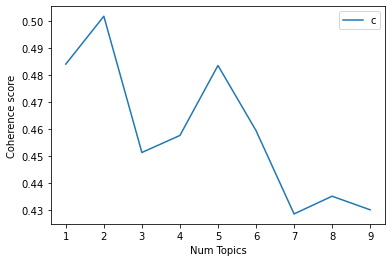

In [88]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=docs, start=1, limit=10, step=1)
# Show graph
import matplotlib.pyplot as plt
limit=10; start=1; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()